<div style="background-color: #c3e8fb; padding: 10px; color: #144d84;">
<b>Exercise 3) Persian Text Classification</b><br>
The main problem with the Persian dataset in the exercise is the presence of empty or low-content files (e.g., fewer than a few words). Please try to improve accuracy by cleaning the dataset. Finally, compare the validation accuracy before and after this process using the sklearn library. Has the F-score for each class increased?
</div>

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.17.1


In [3]:
url = "https://github.com/Alireza-Akhavan/text-classification/raw/main/6-persian-topics.zip"

dataset = tf.keras.utils.get_file("6-persian-topics.zip", url,
                                    extract=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), '6-persian-topics')

16473431/16473431 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
os.listdir(dataset_dir)

['ریاضیات',
 'بهداشت و سلامت',
 'ورزش',
 'فناوری و علوم کاربردی و تکنولوژی',
 'جغرافیا و مکانها',
 'دین و اعتقاد']

### Detecting and removing short txt files

In [5]:
def count_files(directory, max_word_count):
    # Create a dictionary to hold counts for each class
    file_counts = {}

    # Iterate through all folders and files
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)

        # Check if this is a directory
        if os.path.isdir(class_path):
            small_file_count = 0
            total_file_count = 0

            for filename in os.listdir(class_path):
                file_path = os.path.join(class_path, filename)

                # Check if this is a text file
                if filename.endswith('.txt') and os.path.isfile(file_path):
                    total_file_count += 1

                    with open(file_path, 'r', encoding='utf-8') as file:
                        content = file.read()
                        word_count = len(content.split())

                        # Increment count if word count is less than the threshold
                        if word_count < max_word_count:
                            small_file_count += 1

            # Store the counts in the dictionary
            file_counts[class_folder] = {
                'small_file_count': small_file_count,
                'total_file_count': total_file_count
            }

    return file_counts

directory_path = '6-persian-topics'
max_word_count = 15 # این عدد را تغییر میدهیم تا تعداد فایل های حذف شده، نسبت زیادی از کل فایل های یک کلاس نباشد.

file_counts = count_files(directory_path, max_word_count)

for class_name, counts in file_counts.items():
    print(f'{counts["total_file_count"]} txt files exist for the class "{class_name}" ')
    print(f'{counts["small_file_count"]} files have fewer than {max_word_count} words.')
    print('')

379 txt files exist for the class "ریاضیات" 
18 files have fewer than 15 words.

1916 txt files exist for the class "بهداشت و سلامت" 
91 files have fewer than 15 words.

6276 txt files exist for the class "ورزش" 
344 files have fewer than 15 words.

6486 txt files exist for the class "فناوری و علوم کاربردی و تکنولوژی" 
296 files have fewer than 15 words.

21991 txt files exist for the class "جغرافیا و مکانها" 
2123 files have fewer than 15 words.

525 txt files exist for the class "دین و اعتقاد" 
30 files have fewer than 15 words.



In [6]:
def remove_small_files(directory, min_word_count):

    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)

        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                file_path = os.path.join(class_path, filename)

                if filename.endswith('.txt') and os.path.isfile(file_path):
                    with open(file_path, 'r', encoding='utf-8') as file:
                        content = file.read()
                        word_count = len(content.split())

                        if word_count < min_word_count:
                            os.remove(file_path)
                            # print(f'{file_path} removed with number of words: {word_count})')

directory_path = '6-persian-topics'
min_word_count = 15

remove_small_files(directory_path, min_word_count)

### Creating the dataset

In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 34671 files belonging to 6 classes.
Using 27737 files for training.
Found 34671 files belonging to 6 classes.
Using 6934 files for validation.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(10):
    print("Review", text_batch.numpy()[i].decode()) #use decode for persian text
    print("Label", label_batch.numpy()[i])

Review آس جی ام (به انگلیسی: 1 SGM) یک منطقهٔ مسکونی در هند است که در Sri Ganganagar district واقع شده‌است. آس جی ام ۲٬۴۹۳ نفر جمعیت دارد.
Label 1
Review ایستگاه راه‌آهن مرکزی نورنبرگ (انگلیسی: Nuremberg Central Station) ایستگاه اصلی راه‌آهن در شهر نورنبرگ، آلمان است.
Label 1
Review شهر ویوپنت، سن-سن-دنی (به فرانسوی: ویوپنت، سن-سن-دنی) در شهرستان سن-سن-دنی در ناحیه ایل-دو-فرانس با جمعیت ۳۵٬۵۹۲ در کشور فرانسه واقع شده‌است
Label 1
Review کشتی در بازی‌های المپیک تابستانی ۱۹۲۸ نام رویداد ورزش کشتی در بازی‌های المپیک تابستانی بود که در سال ۱۹۲۸ برگزار شد.
Label 5
Review در ریاضیات و به خصوص در منطق ریاضی، جبر بولی (به انگلیسی: Boolean algebra) زیر مجموعه‌ای از جبر است که در آن مقدار متغیرها، درست یا غلط می‌باشد که معمولاً به همین ترتیب با ۱ و ۰ نشان داده می‌شوند. به جای جبر مقدماتی که در آن مقدار متغیرها اعداد هستند و عملگرهای اصلی جمع و ضرب می‌باشند، عملگرهای اصلی جبر بولی عطف منطقی و که با ∧ نشان داده می‌شود، فصل منطقی یا که با ∨ نشان داده می‌شود و نقیض که با ¬ نشان داده می‌شود، می‌باشند.

In [9]:
for i in range(6):
  print("Label {} corresponds to {}".format(i, raw_train_ds.class_names[i]))

Label 0 corresponds to بهداشت و سلامت
Label 1 corresponds to جغرافیا و مکانها
Label 2 corresponds to دین و اعتقاد
Label 3 corresponds to ریاضیات
Label 4 corresponds to فناوری و علوم کاربردی و تکنولوژی
Label 5 corresponds to ورزش


### Preprocess data

In [10]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  stripped_ye = tf.strings.regex_replace(stripped_html, 'ي', 'ی')
  return tf.strings.regex_replace(stripped_ye,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [11]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [12]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [13]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [14]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review.numpy().decode())
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review ایالت ایمو (به لاتین: Imo (state)) یک ایالت در نیجریه است که ۵٬۵۳۰ کیلومترمربع مساحت و ۳٬۹۳۴٬۸۹۹ نفر جمعیت دارد.
Label جغرافیا و مکانها
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  67,    1,    3,   36,    1, 1535,    9,   67,    2, 1319,    5,
           6,    1,  326,   53,    4,    1,   18,   19,   20,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 

In [15]:
a, b = next(iter(raw_train_ds))
print(a.shape, b.shape)

(32,) (32,)


In [16]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

In [17]:
a, b = next(iter(train_ds))
a[0]

<tf.Tensor: shape=(250,), dtype=int64, numpy=
array([   1, 4077, 6403,   25,    1, 4077, 6403,   12,    1,    1,    1,
          2, 4485,  480, 2069,    1,  572,    3,  293,  606,    1,    2,
       5647,  259,   10,   11,    6,  128,    1,    4, 8953,   52,   32,
         45, 4191,  345, 2274,    1,   33,    1,    1, 2713,    9, 1254,
        121,    2,  962,    6,    1,   61,    1,    2,   78,  107, 1997,
          9,    1,   25,    1,   39,   20,    6, 3676,    1, 1993,   22,
          2,    9,    1, 1137,  209,    1,    2,  695,   13,    1,  769,
          4, 3572, 6723,   32, 2291,    6, 1146,  700,  328, 2408,    7,
         15, 1381, 4987,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

### Configure the dataset for performance

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [19]:
embedding_dim = 16

In [20]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(100),
  layers.Dropout(0.5),
  layers.Dense(6)])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

## calculate class weight

In [22]:
# Convert the tf.data.Dataset to a NumPy iterator
train_iterator = train_ds.as_numpy_iterator()

# Create a dictionary to store the counts for each class
class_counts = {}

# Iterate over the dataset and count the samples for each class
for data, labels in train_iterator:
    for label in labels:
        class_counts[label] = class_counts.get(label, 0) + 1

# Calculate the class weights
total_samples = sum(class_counts.values())
class_weights = {
    label: total_samples / count
    for label, count in class_counts.items()
}

# Print the class counts
for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")

# Print the class weights
for label, weight in class_weights.items():
    print(f"Class {label} weight: {weight}")


Class 1: 15901 samples
Class 4: 4922 samples
Class 0: 1454 samples
Class 5: 4764 samples
Class 2: 409 samples
Class 3: 287 samples
Class 1 weight: 1.7443557008993145
Class 4 weight: 5.635310849248273
Class 0 weight: 19.076341127922973
Class 5 weight: 5.822208228379513
Class 2 weight: 67.81662591687042
Class 3 weight: 96.64459930313589


### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
      monitor='val_loss',
      patience=7,
      verbose=1,
      restore_best_weights=True
      )

reduce_lr = ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.5,
      patience=4,
      verbose=1,
      min_lr=1e-7
      )

epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr])

Epoch 1/30
867/867 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.2842 - loss: 10.5066 - val_accuracy: 0.8037 - val_loss: 0.8185 - learning_rate: 0.0010
Epoch 2/30
867/867 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8372 - loss: 5.9951 - val_accuracy: 0.8879 - val_loss: 0.3564 - learning_rate: 0.0010
Epoch 3/30
867/867 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9059 - loss: 3.6299 - val_accuracy: 0.9361 - val_loss: 0.2005 - learning_rate: 0.0010
Epoch 4/30
867/867 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9287 - loss: 2.3265 - val_accuracy: 0.9602 - val_loss: 0.1193 - learning_rate: 0.0010
Epoch 5/30
867/867 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9438 - loss: 1.7605 - val_accuracy: 0.9652 - val_loss: 0.1080 - learning_rate: 0.0010
Epoch 6/30
867/867 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9516 - loss: 1.4258 - val_accuracy: 0.9647 - val_loss: 0.1165 - learning_rate: 0.0010
Epoch 7/30
867/867 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9630 - loss: 0.9953 -

In [28]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9855 - loss: 0.0851
Validation Loss: 0.08669081330299377, Validation Accuracy: 0.9834150671958923


#### we reached the accuracy of 98 on the validation data

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

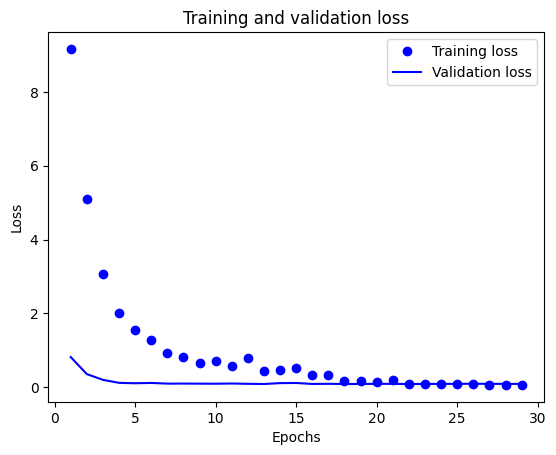

In [32]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

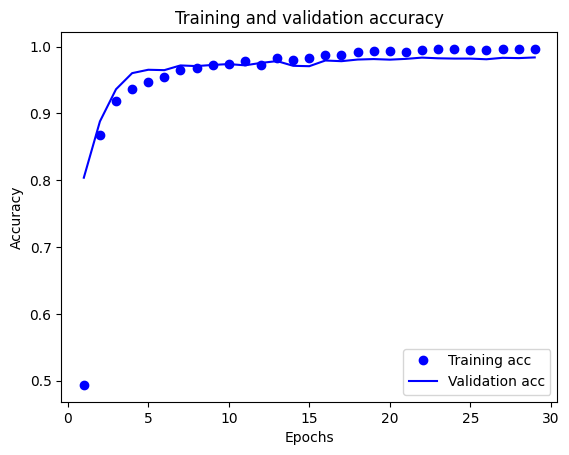

In [33]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export the model


In [37]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
a = export_model.evaluate(raw_val_ds)
print(a)

217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9853 - loss: 0.0000e+00
[0.0, 0.0, 0.9834150671958923, 0.9834150671958923]


### Inference on new data


In [38]:
import numpy as np

In [48]:
examples = tf.convert_to_tensor([
  "استفاده از الکل صنعتی برای ضدعفونی کردن توصیه نمیشود.",
  "علوم کامپیوتر رشته ای مجزا از مهندسی کامپیوتر است و بر ریاضیات تمرکز دارد.",
  "دهلی یکی از مهم ترین شهر های هند محسوب میشود."
])

p = export_model.predict(examples)
results = np.argmax(p, axis=1)

for r in results:
  print(raw_train_ds.class_names[r])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
بهداشت و سلامت
فناوری و علوم کاربردی و تکنولوژی
جغرافیا و مکانها


## Confusion matrix

In [49]:
features = raw_val_ds.map(lambda x, y: x)
labels = raw_val_ds.map(lambda x, y: y)

In [50]:
predictions = export_model.predict(features)
predicted_classes = tf.math.argmax(predictions, axis=-1)

217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [51]:
# Get the actual data from the MapDataset object
labels_list = list(labels.as_numpy_iterator())

# Flatten the batched labels
labels = np.concatenate(labels_list, axis=0)

In [52]:
confusion_mtx = tf.math.confusion_matrix(labels, predicted_classes)
confusion_mtx

<tf.Tensor: shape=(6, 6), dtype=int32, numpy=
array([[  22,  206,    4,    3,   70,   66],
       [ 206, 2269,   46,   28,  731,  687],
       [   4,   49,    2,    1,   14,   16],
       [   3,   45,    0,    1,   14,   11],
       [  82,  715,   12,   13,  244,  202],
       [  61,  674,   15,   10,  218,  190]], dtype=int32)>

In [53]:
!pip install arabic_reshaper
!pip install python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 6.9 MB/s eta 0:00:00


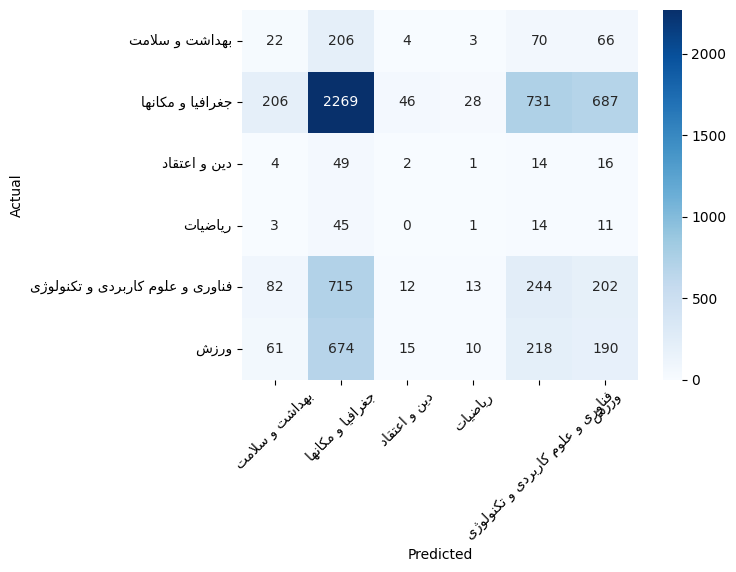

In [55]:
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display

def convert_text(t):
    reshaped_text = arabic_reshaper.reshape(t) # seperated chars problem
    bidi_text = get_display(reshaped_text) #direction problem
    text = bidi_text.encode().decode('utf-8') #encoding problem (rectangular boxes!)
    return text

class_names = [convert_text(t) for t in raw_train_ds.class_names]

sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(class_names))+0.5, class_names, rotation=45)
plt.yticks(np.arange(len(class_names))+0.5, class_names, rotation=0)

plt.show()

In [56]:
from sklearn.metrics import classification_report
report = classification_report(labels, predicted_classes)

for i in range(6):
  print("Label {} corresponds to {}".format(i, raw_train_ds.class_names[i]))
print(report)

Label 0 corresponds to بهداشت و سلامت
Label 1 corresponds to جغرافیا و مکانها
Label 2 corresponds to دین و اعتقاد
Label 3 corresponds to ریاضیات
Label 4 corresponds to فناوری و علوم کاربردی و تکنولوژی
Label 5 corresponds to ورزش
              precision    recall  f1-score   support

           0       0.06      0.06      0.06       371
           1       0.57      0.57      0.57      3967
           2       0.03      0.02      0.02        86
           3       0.02      0.01      0.02        74
           4       0.19      0.19      0.19      1268
           5       0.16      0.16      0.16      1168

    accuracy                           0.39      6934
   macro avg       0.17      0.17      0.17      6934
weighted avg       0.39      0.39      0.39      6934

